In [1]:
import numpy as np
from itertools import combinations
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib
import sys
# sys.path.append('../scores')
# from interactions import *
# from pdpbox import pdp
import pandas as pd
import os
from scipy.stats import random_correlation
from copy import deepcopy
from os.path import join as oj
from tqdm import tqdm
import pickle as pkl
import seaborn as sns
# from run_sim import *
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

# analyze curves

In [15]:
out_dir = '/scratch/users/vision/chandan/boosting_no_rf/iid_stability'
# print(os.listdir(out_dir))
curves_list = [pkl.load(open(oj(out_dir, fname), 'rb')) for fname in os.listdir(out_dir) if 'curves' in fname and '1_' in fname]

In [16]:
mse_dac, mse_pdp = [], []
corr_dac, corr_pdp = [], []
for func_num in range(len(curves_list)):
    curves = curves_list[func_num]
    for i in range(len(curves)):
        try:
            curves_i = curves[i]
            exp = curves_i['exp']
            dac = curves_i['dac']
            pdp_xi = curves_i['pdp']
#             print('shapes', exp.shape, dac.shape, pdp_xi.shape)

            # try things so we don't append unless they both append
            np.nanmean((exp - dac) ** 2)
            np.nanmean((exp - pdp_xi) ** 2)
    
            # actually append
#             mse_dac.append(np.nanmean((exp - dac) ** 2))
#             mse_pdp.append(np.nanmean((exp - pdp_xi) ** 2))
            mse_dac.append(np.nanmean((exp - dac) ** 2))
            mse_pdp.append(np.nanmean((exp - pdp_xi) ** 2))
            
            corr_dac.append(np.ma.corrcoef(dac, exp)[0, 1])
            corr_pdp.append(np.ma.corrcoef(pdp_xi, exp)[0, 1])
        except Exception as e:
#             print(e)
            pass

**plot results**

	  dac,   pdp
mse means 0.081, 0.350


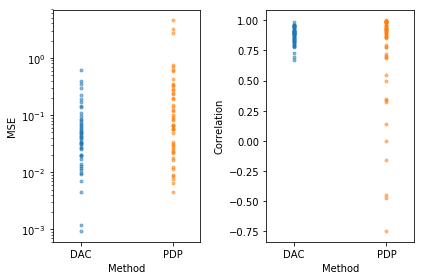

In [17]:
# plt.figure(figsize=(4, 2))
R, C = 1, 2
plt.subplot(R, C, 1)
plt.plot([0] * len(mse_dac), mse_dac, '.', alpha=0.5)
plt.plot([1] * len(mse_pdp), mse_pdp, '.', alpha=0.5)
plt.ylabel('MSE')
plt.yscale('log')
plt.xticks([0, 1], ['DAC', 'PDP'])
plt.xlim((-0.3, 1.3))
plt.xlabel('Method')


plt.subplot(R, C, 2)
plt.plot([0] * len(corr_dac), corr_dac, '.', alpha=0.5)
plt.plot([1] * len(corr_pdp), corr_pdp, '.', alpha=0.5)
plt.ylabel('Correlation')
plt.xticks([0, 1], ['DAC', 'PDP'])
plt.xlim((-0.3, 1.3))
plt.xlabel('Method')

plt.tight_layout()

print('\t  dac,   pdp')
print(f'mse means {np.nanmean(mse_dac):0.3f}, {np.nanmean(mse_pdp):0.3f}')
# print(f'corr means {np.nanmean(corr_dac):0.3f}, {np.nanmean(corr_pdp):0.3f}')
# print(f'mse medians {np.median(mse_dac):0.3f}, {np.median(mse_pdp):0.3f}')
# print(f'corr medians {np.median(corr_dac):0.3f}, {np.median(corr_pdp):0.3f}')
plt.show()

# print table

In [18]:
mse_dac = np.array(mse_dac)
mse_pdp = np.array(mse_pdp)
idxs = ~np.isnan(mse_dac) * ~np.isnan(mse_pdp) * (mse_pdp < 1e6)

print(f'& {np.nanmean(mse_dac):0.3f} $\pm$ {np.nanmean(mse_dac) / np.sqrt(len(mse_dac[idxs])):0.3f} & \
    {np.nanmean(mse_pdp):0.3f} $\pm$ {np.nanmean(mse_pdp) / np.sqrt(len(mse_pdp[idxs])):0.3f} \\\\') # & \
#     {np.mean(corr_dac):0.3f} $\pm$ {np.mean(corr_dac) / np.sqrt(len(corr_dac)):0.3f} & \
#     {np.mean(corr_pdp):0.3f} $\pm$ {np.mean(corr_pdp) / np.sqrt(len(corr_pdp)):0.3f}')

print('num_pts', mse_dac[idxs].size)

& 0.081 $\pm$ 0.011 &     0.350 $\pm$ 0.050 \\
num_pts 50


**look at curves**

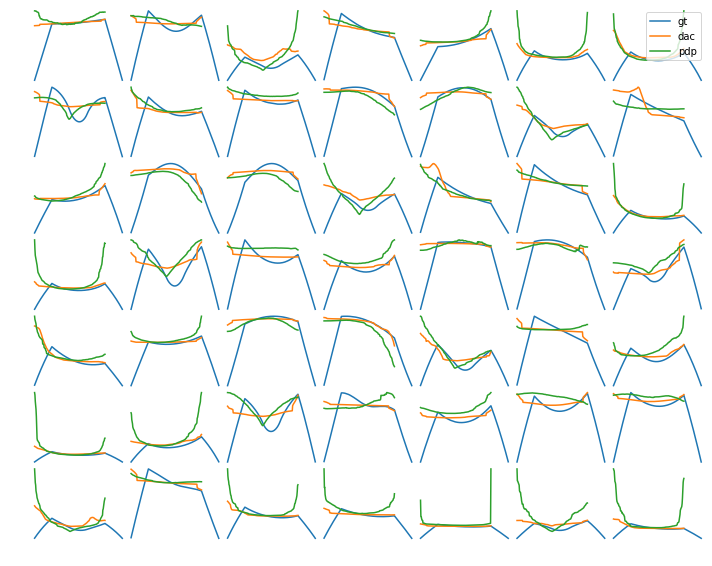

In [19]:
num_vars = 10
R, C = 7, 7
count = 1
plt.figure(figsize=(10, 8))
for func_num in range(10):
    curves = curves_list[func_num]
    
    for i in range(len(curves)):
        if count > R * C:
            break        
        plt.subplot(R, C, count)
        
        try:
            curves_i = curves[i]
            
            # smooth the exp
            exp = curves_i['exp']
            
            smooth_num = 50
#             exp = np.repeat(np.nanmean(exp.reshape(-1, smooth_num), axis=1), smooth_num)

            mask = np.isnan(exp)
            exp[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), exp[~mask])
        
            w = np.ones(smooth_num) / smooth_num
            exp = np.convolve(w, exp)

            plt.plot(exp, label='gt')
            
            plt.plot(curves_i['dac'], label='dac')
            plt.plot(curves_i['pdp'], label='pdp')
#             plt.plot(curves_i['exp_train'], label='exp_train')            
            plt.axis('off')
            if count == C:
                plt.legend()

            count += 1
        except Exception as e:
            print(e)

            
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('curves_real.pdf')
plt.show()